参考文档 https://deepmatch.readthedocs.io/en/latest/Features.html
参考代码 https://github.com/shenweichen/DeepMatch/blob/master/examples/colab_MovieLen1M_DSSM_InBatchSoftmax.ipynb
不考虑代码冗余的情况，熟悉tensorflow环境的背景下，重复用几遍。后面再考虑抽象公共函数

# 1、处理数据

In [1]:
import pandas as pd

data_path="../推荐算法-双塔/ml-1m"
unames = ['user_id','gender', 'age','occupation','zip']
user_df = pd.read_csv(data_path+'/users.dat', sep='::',
                      engine="python",
                      encoding='iso-8859-1',
                      header=None, names=unames)
rnames = ['user_id','movie_id','rating','timestamp']
rating_df = pd.read_csv(data_path+'/ratings.dat', sep='::',
                     engine='python',encoding='iso-8859-1',
                     header=None, names=rnames)
mnames = ['movie_id','title','genres']
movie_df = pd.read_csv(data_path+'/movies.dat',sep='::',
                    engine="python",encoding='iso-8859-1',
                    header=None, names=mnames)
data = pd.merge(pd.merge(user_df, rating_df), movie_df)
data.tail(10)

,user_id,gender,age,occupation,zip,movie_id,rating,timestamp,title,genres
1000199,5334,F,56,13,46140,3382,5,960796159,Song of Freedom (1936),Drama
1000200,5420,F,1,19,14850,1843,3,960156505,Slappy and the Stinkers (1998),Children's|Comedy
1000201,5433,F,35,17,45014,286,3,960240881,Nemesis 2: Nebula (1995),Action|Sci-Fi|Thriller
1000202,5494,F,35,17,94306,3530,4,959816296,Smoking/No Smoking (1993),Comedy
1000203,5556,M,45,6,92103,2198,3,959445515,Modulations (1998),Documentary
1000204,5949,M,18,17,47901,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,M,35,14,30030,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,M,18,17,92886,2845,1,958153068,White Boys (1999),Drama
1000207,5851,F,18,20,55410,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
1000208,5938,M,25,1,35401,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


In [2]:
data.shape

(1000209, 10)

# 2、构建特征序列

In [3]:
sparse_features = ['user_id','gender','age','occupation','zip','movie_id','genres']

In [4]:
from sklearn.preprocessing import LabelEncoder
# labelEncoder的说明 
# https://zhuanlan.zhihu.com/p/33569866
# 注意这个没有把对应的genres的多分类
feature_max_idx = {}
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1
    feature_max_idx[feature] = data[feature].max() + 1
data.tail(3)

,user_id,gender,age,occupation,zip,movie_id,rating,timestamp,title,genres
1000206,5780,2,2,18,2999,2639,1,958153068,White Boys (1999),240
1000207,5851,1,2,21,1906,3368,5,957756608,One Little Indian (1973),192
1000208,5938,2,3,2,1266,2703,4,957273353,"Five Wives, Three Secretaries and Me (1998)",236


In [5]:
#zip() 函数是 Python 内置函数之一，它可以将多个序列（列表、元组、字典、集合、字符串以及 range() 区间
#构成的列表）“压缩”成一个 zip 对象。所谓“压缩”，其实就是将这些序列中对应位置的元素重新组合，生成一个个新的元组。
#http://c.biancheng.net/view/2237.html

from tqdm import tqdm,trange
import numpy as np
import random
def gen_data_set(data, seq_max_len=50, negsample=0):
    train_set = []
    test_set = []
    
    data.sort_values('timestamp', inplace=True)
    item_ids = data['movie_id'].unique()
    #print(item_ids[:3])
    item_id_genres_map = dict(zip(data['movie_id'].values, data['genres'].values))
    #print(item_id_genres_map[858])
    
    #tqdm是一个方便且易于扩展的Python进度条，可以在python执行长循环时在命令行界面实时地显示一个进度提示信息，包括执行进度、处理速度等信息，且可在一定程度上进行定制。
    for reviewerID, hist in data.groupby('user_id'):
        pos_list = hist['movie_id'].tolist()
        #print(pos_list[:3])
        genres_list = hist['genres'].tolist()
        rating_list = hist['rating'].tolist()
        
        #全局正样本中负采样
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))
            neg_list = np.random.choice(candidate_set, size=len(pos_list)*negsample)
        for i in range(1, len(pos_list)):
            #取到前i个
            hist = pos_list[:i]
            genres_hist = genres_list[:i]
            seq_len = min(i, seq_max_len)
            #https://blog.csdn.net/weixin_35757704/article/details/124037380
            #[::]列表[起始:终止:步长]，默认是my_list[0:-1:1]
            #[::3]等同于my_list[0:-1:3],步长为正从做往右，步长为负，从右往左
            #hist[::-1][:seq_len] 逆序取了seq_len个
            #如果不是最后一个
            if i != len(pos_list) - 1:
               train_set.append((reviewerID, pos_list[i], 1, 
                                hist[::-1][:seq_len],
                                seq_len, 
                                genres_hist[::-1][:seq_len],
                                genres_list[i],
                                rating_list[i])) 
               for negi in range(negsample):
                    train_set.append((reviewerID, neg_list[i * negsample + negi], 0, 
                                hist[::-1][:seq_len],
                                seq_len, 
                                genres_hist[::-1][:seq_len],
                                item_id_genres_map[neg_list[i * negsample + negi]]))
            else:#每一个用户的最后一个正样本用于测试
                test_set.append((reviewerID, pos_list[i], 1, hist[::-1][:seq_len], seq_len, genres_hist[::-1][:seq_len],
                                 genres_list[i],
                                 rating_list[i]))
    random.shuffle(train_set)
    random.shuffle(test_set)
    print(len(train_set[0]),len(test_set[0]))
                  
    return train_set, test_set
    
SEQ_LEN = 50
#这里设置为0， 用batch内负采样
negsample = 0
train_set, test_set = gen_data_set(data, SEQ_LEN, negsample)

8 8


In [6]:
len(train_set)

988129

In [7]:
user_profile = data[['user_id','gender','age','occupation','zip']].drop_duplicates('user_id')
item_profile  = data[['movie_id','genres']].drop_duplicates('movie_id')
#最后还有一个参数 inplace=True 表示直接修改 df, 而不是返回新对象
user_profile.set_index('user_id', inplace=True)
#user_profile.index
user_item_list = data.groupby('user_id')['movie_id'].apply(list)
user_item_list.head()

user_id
1    [2970, 958, 1575, 1179, 2148, 1659, 3178, 1118...
2    [1109, 1128, 1121, 2513, 1202, 2736, 1136, 110...
3    [580, 2652, 3302, 1789, 1782, 1328, 1175, 3430...
4    [1121, 1026, 467, 3295, 3236, 1107, 254, 1109,...
5    [848, 2513, 859, 347, 1159, 1051, 2652, 2008, ...
Name: movie_id, dtype: object

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def gen_model_input(train_set, user_profile, seq_max_len):
    train_uid = np.array([line[0] for line in train_set])
    #print(train_uid[:3])
    #[5111 1264 4867]
    #正样本的movie_id
    train_iid = np.array([line[1] for line in train_set])
    train_label = np.array([line[2] for line in train_set])
    train_seq = [line[3] for line in train_set]
    #print(train_seq[:3])
    #[[1900, 2826, 2872, 1975, 358, 3190, 1740, 1346, 1216, 2163, 3032, 3369, 990, 1928, 3043, 1223, 1970, 1179, 3220, 2711, 1088, 1007, 2719, 2054, 339, 67, 1049, 1122, 1343, 855, 2833, 1174, 964, 1201, 695, 1769, 3430, 1696, 1505, 1168, 1008, 867, 1085, 1194, 1341, 3315, 1178, 3272, 1706, 3135], [97, 1513, 2796, 1101, 1217, 157, 1047, 240, 1264, 1705, 2930, 1365, 1932, 2969, 418, 561, 1211, 3047, 2282, 495, 2923, 61, 3027, 1268, 1011, 1536, 2241, 1619, 1779, 243, 1934, 1638, 1303, 314, 2530, 1295, 1180, 470, 1783, 2079, 3248, 2722, 1357, 2890, 549, 1891, 3032, 2857, 2160, 2945], [1161, 859, 2880, 1251, 1067, 568, 50, 299, 1567, 288, 1100, 1203, 2160, 2476, 1202, 2806, 3435, 3198, 1296, 2097, 1009, 3511, 229, 1815, 2558, 2059, 3272, 2401, 2587, 32, 2006, 145, 1119, 1831, 1564, 1163, 1134, 860, 1198, 1990, 1213, 1060, 1111, 1105, 2786, 1085, 1114, 853, 2109, 852]]
    train_hist_len = np.array([line[4] for line in train_set])
    train_seq_genres = np.array([line[5] for line in train_set],dtype=list)
    train_genres = np.array([line[6] for line in train_set])
    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    train_seq_genres_pad = pad_sequences(train_seq_genres, maxlen=seq_max_len, padding='post', truncating='post',
                                         value=0)
    
    train_model_input = {"user_id": train_uid, "movie_id": train_iid, "hist_movie_id": train_seq_pad,
                    "hist_genres": train_seq_genres_pad,
                    "hist_len": train_hist_len, "genres": train_genres}
    for key in ["gender", "age", "occupation", "zip"]:
        train_model_input[key] = user_profile.loc[train_model_input['user_id']][key].values
    return train_model_input, train_label
    
train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)


In [9]:
type(train_set[0][5])

list

In [10]:
train_model_input['user_id'][:4]

array([4007, 2419, 1131, 5451])

# 3、count #unique features for each sparse field and generate feature config for sequence feature

In [11]:
#https://blog.csdn.net/liboshi123/article/details/110550681
#namedtuple()是产生具有命名字段的元组的工厂函数，namedtuple 比普通tuple具有更好的可读性，可以使代码更易于维护。同时与字典相比，又更加的轻量和高效。
#namedtuple(typename, field_names,*,verbos=False, rename=Flase)
#返回一个新类，名为typename

#https://blog.csdn.net/Florine113/article/details/120988102
#cls在python中表示类本身，self为类的一个实例。
#cls可以返回类的一个实例。
from collections import namedtuple
import tensorflow as tf

DEFAULT_GROUP_NAME = "default_group"

class SparseFeat(namedtuple('SparseFeat',
                            ['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'vocabulary_path', 'dtype', 'embeddings_initializer',
                             'embedding_name',
                             'group_name', 'trainable'])):
    __slots__ = ()
    
    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype="int32", embeddings_initializer=None,
                embedding_name=None,
                group_name=DEFAULT_GROUP_NAME, trainable=True):

        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))
        if embeddings_initializer is None:
            embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=2020)

        if embedding_name is None:
            embedding_name = name

        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, vocabulary_path, dtype,
                                              embeddings_initializer,
                                              embedding_name, group_name, trainable)
SparseFeat('user_id', feature_max_idx['user_id'], 16)


SparseFeat(name='user_id', vocabulary_size=6041, embedding_dim=16, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x7fe3443368f0>, embedding_name='user_id', group_name='default_group', trainable=True)

In [12]:
feature_max_idx

{'user_id': 6041,
 'gender': 3,
 'age': 8,
 'occupation': 22,
 'zip': 3440,
 'movie_id': 3707,
 'genres': 302}

In [13]:
class VarLenSparseFeat(namedtuple('VarLenSparseFeat',
                                  ['sparsefeat', 'maxlen', 'combiner', 'length_name', 'weight_name', 'weight_norm'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None, weight_name=None, weight_norm=True):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name, weight_name,
                                                    weight_norm)

    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def use_hash(self):
        return self.sparsefeat.use_hash

    @property
    def vocabulary_path(self):
        return self.sparsefeat.vocabulary_path

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embeddings_initializer(self):
        return self.sparsefeat.embeddings_initializer

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    @property
    def trainable(self):
        return self.sparsefeat.trainable

    def __hash__(self):
        return self.name.__hash__()
    
VarLenSparseFeat(SparseFeat('hist_movie_id', feature_max_idx['movie_id'], 32,
                                                    embedding_name="movie_id"), SEQ_LEN, 'mean', 'hist_len')

VarLenSparseFeat(sparsefeat=SparseFeat(name='hist_movie_id', vocabulary_size=3707, embedding_dim=32, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x7fe344373be0>, embedding_name='movie_id', group_name='default_group', trainable=True), maxlen=50, combiner='mean', length_name='hist_len', weight_name=None, weight_norm=True)

In [14]:
class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype', 'transform_fn'])):
    """ Dense feature
    Args:
        name: feature name.
        dimension: dimension of the feature, default = 1.
        dtype: dtype of the feature, default="float32".
        transform_fn: If not `None` , a function that can be used to transform
        values of the feature.  the function takes the input Tensor as its
        argument, and returns the output Tensor.
        (e.g. lambda x: (x - 3.0) / 4.2).
    """
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32", transform_fn=None):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype, transform_fn)

    def __hash__(self):
        return self.name.__hash__()

In [15]:
embedding_dim = 32

user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], 16),
                        SparseFeat("gender", feature_max_idx['gender'], 16),
                        SparseFeat("age", feature_max_idx['age'], 16),
                        SparseFeat("occupation", feature_max_idx['occupation'], 16),
                        SparseFeat("zip", feature_max_idx['zip'], 16),
                        VarLenSparseFeat(SparseFeat('hist_movie_id', feature_max_idx['movie_id'], embedding_dim,
                                                    embedding_name="movie_id"), SEQ_LEN, 'mean', 'hist_len'),
                        VarLenSparseFeat(SparseFeat('hist_genres', feature_max_idx['genres'], embedding_dim,
                                embedding_name="genres"), SEQ_LEN, 'mean', 'hist_len'),
                        ]

item_feature_columns = [SparseFeat('movie_id', feature_max_idx['movie_id'], embedding_dim),
                        SparseFeat('genres', feature_max_idx['genres'], embedding_dim)
                       ]
user_feature_columns

[SparseFeat(name='user_id', vocabulary_size=6041, embedding_dim=16, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x7fe3443735e0>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='gender', vocabulary_size=3, embedding_dim=16, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x7fe344371330>, embedding_name='gender', group_name='default_group', trainable=True),
 SparseFeat(name='age', vocabulary_size=8, embedding_dim=16, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<keras.initializers.initializers_v2.RandomNormal object at 0x7fe344371ed0>, embedding_name='age', group_name='default_group', trainable=True),
 SparseFeat(name='occupation', vocabulary_size=22, embedding_dim=16, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initialize

In [16]:
from collections import Counter 
#https://blog.csdn.net/qq_29678299/article/details/89975667
#dict的子类，用于计数
train_counter = Counter(train_model_input['movie_id'])
#train_counter， 以上求得movie_id分别对应的样本数
#{525: 570,427: 1135,1505: 1363,956: 640,901: 334,....2073: 574}
# train_counter.get(525,0) -> 570
#item_count 次数的list【0，2174,.......】
item_count = [train_counter.get(i,0) for i in range(item_feature_columns[0].vocabulary_size)]

In [17]:
class NegativeSampler(
    namedtuple('NegativeSampler', ['sampler', 'num_sampled', 'item_name', 'item_count', 'distortion'])):
    """ NegativeSampler
    Args:
        sampler: sampler name,['inbatch', 'uniform', 'frequency' 'adaptive',] .
        num_sampled: negative samples number per one positive sample.
        item_name: pkey of item features .
        item_count: global frequency of item .
        distortion: skew factor of the unigram probability distribution.
    """
    __slots__ = ()

    def __new__(cls, sampler, num_sampled, item_name, item_count=None, distortion=1.0, ):
        if sampler not in ['inbatch', 'uniform', 'frequency', 'adaptive']:
            raise ValueError(' `%s` sampler is not supported ' % sampler)
        if sampler in ['inbatch', 'frequency'] and item_count is None:
            raise ValueError(' `item_count` must not be `None` when using `inbatch` or `frequency` sampler')
        return super(NegativeSampler, cls).__new__(cls, sampler, num_sampled, item_name, item_count, distortion)

In [18]:
#注意这里的item_count 是上面的list。
sampler_config = NegativeSampler('inbatch',num_sampled=255,item_name="movie_id",item_count=item_count)

# 4、搭建模型

Embedding 使用方法, tf.keras.layers.Embedding
tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)

In [19]:
#python中OrderedDict用法， 有序的字典
import collections

def build_input_features(feature_columns, prefix=''):
    input_features = collections.OrderedDict() #思考，这里为什么要用有序字典
  
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            input_features[fc.name] = tf.keras.Input(
                shape=(1,), name=prefix + fc.name, dtype=fc.dtype)
        elif isinstance(fc, DenseFeat):
            input_features[fc.name] = tf.keras.Input(
                shape=(fc.dimension,), name=prefix + fc.name, dtype=fc.dtype)
        elif isinstance(fc, VarLenSparseFeat):
            input_features[fc.name] = tf.keras.Input(shape=(fc.maxlen,), name=prefix + fc.name,
                                            dtype=fc.dtype)
            if fc.weight_name is not None:
                input_features[fc.weight_name] = tf.keras.Input(shape=(fc.maxlen, 1), name=prefix + fc.weight_name,
                                                       dtype="float32")
            if fc.length_name is not None:
                input_features[fc.length_name] = tf.keras.Input((1,), name=prefix + fc.length_name, dtype='int32')

        else:
            raise TypeError("Invalid feature column type,got", type(fc))

    return input_features
#测试
build_input_features(user_feature_columns)

OrderedDict([('user_id',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'user_id')>),
             ('gender',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'gender')>),
             ('age',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'age')>),
             ('occupation',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'occupation')>),
             ('zip',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'zip')>),
             ('hist_movie_id',
              <KerasTensor: shape=(None, 50) dtype=int32 (created by layer 'hist_movie_id')>),
             ('hist_len',
              <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'hist_len')>),
             ('hist_genres',
              <KerasTensor: shape=(None, 50) dtype=int32 (created by layer 'hist_genres')>)])

In [20]:
#表达式中使用if else,意思是if成立执行左边，否则执行右边
def create_embedding_matrix(feature_columns, l2_reg, seed, prefix="sparse", seq_mask_zero=True):
    sparse_emb_dict = {}
    
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    
    for feat in sparse_feature_columns:
        emb = tf.keras.layers.Embedding(feat.vocabulary_size, feat.embedding_dim,
                        embeddings_initializer=feat.embeddings_initializer,
                        embeddings_regularizer=tf.keras.regularizers.L2(l2_reg),
                        name=prefix + '_emb_' + feat.embedding_name)
        emb.trainable = feat.trainable
        sparse_emb_dict[feat.embedding_name] = emb
    
    #varlen_sparse_feature 对比 sparse_feature， 
    #1、多了，mask_zero=seq_mask_zero
    #2、名字不同
    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []
    
    if varlen_sparse_feature_columns and len(varlen_sparse_feature_columns) > 0:
        for feat in varlen_sparse_feature_columns:
            # if feat.name not in sparse_embedding:
            emb = tf.keras.layers.Embedding(feat.vocabulary_size, feat.embedding_dim,
                            embeddings_initializer=feat.embeddings_initializer,
                            embeddings_regularizer=tf.keras.regularizers.L2(
                                l2_reg),
                            name=prefix + '_seq_emb_' + feat.name,
                            mask_zero=seq_mask_zero)
            emb.trainable = feat.trainable
            sparse_emb_dict[feat.embedding_name] = emb
            
    return sparse_emb_dict

In [21]:
#测试
tensor = tf.constant([[1, 2, 3], [4, 5, 6]])
tensor = tf.ones_like(tensor) * (-2 ** 32 + 1)
tensor

2022-11-29 15:39:48.833369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [22]:
#WeightedSequenceLayer(weight_normalization=fc.weight_norm)(
#                   [embedding_dict[feature_name], features[feature_length_name], features[fc.weight_name]])
#其中
#embedding_dict,varlen_embedding_lookup 中查找的经过变换embedding变换的output{'user_id': XXX, .......}
#features, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#fc的属性 length_name='hist_len', weight_name=None, weight_norm=True

#功能
#如果fc.weight_name is  None:则直接用原来embedding的输出。
#如果fc.weight_name is  not None，WeightedSequenceLayer加权，如果有feature_length_name, 则传入，否则不传入。三个，见例子
#如果有feature_length_name，SequencePoolingLayer的supports_masking=False
#如果没有feature_length_name，SequencePoolingLayer的supports_masking=True
class WeightedSequenceLayer(tf.keras.layers.Layer):
    """The WeightedSequenceLayer is used to apply weight score on variable-length sequence feature/multi-value feature.

      Input shape
        - A list of two  tensor [seq_value,seq_len,seq_weight]

        - seq_value is a 3D tensor with shape: ``(batch_size, T, embedding_size)`` T应该是多少个值

        - seq_len is a 2D tensor with shape : ``(batch_size, 1)``,indicate valid length of each sequence.

        - seq_weight is a 3D tensor with shape: ``(batch_size, T, 1)``

      Output shape
        - 3D tensor with shape: ``(batch_size, T, embedding_size)``.

      Arguments
        - **weight_normalization**: bool.Whether normalize the weight score before applying to sequence.

        - **supports_masking**:If True,the input need to support masking.
    """
    def __init__(self, weight_normalization=True, supports_masking=False, **kwargs):
        super(WeightedSequenceLayer, self).__init__(**kwargs)
        self.weight_normalization = weight_normalization
        self.supports_masking = supports_masking
    
    def build(self, input_shape):
        super(WeightedSequenceLayer, self).build(input_shape)# Be sure to call this somewhere!
        if not self.supports_masking:
            self.seq_len_max = int(input_shape[0][1])
    def call(self, input_list, mask=None, **kwargs):
        if self.supports_masking:
            if mask is None:
                raise ValueError("When supports_masking is true, please input mask")
            key_input, value_input = input_list
            #expand_dims Returns a tensor with a length 1 axis inserted at index axis.
            #tf.expand_dims(input, axis, name=None)
            #image = tf.zeros([10,10,3])  
            #tf.expand_dims(image, axis=0).shape.as_list()   [1,10,10,3] 
            #tf.expand_dims(image, axis=-1).shape.as_list()   [10,10,3,1]
            mask = tf.expand_dims(mask[0], axis=2)
        else :
            #分别是embedding_dict[feature_name], features[feature_length_name], features[fc.weight_name]
            #即feature对应的embedding的输出，'hist_len‘对应的input tensor， 以及 'weight_name'对应的input tensor
            key_input, key_length_input, value_input = input_list
            #sequence_mask, https://www.cnblogs.com/qianyuesheng/p/16445654.html
            #输入是一个数，所以返回是一个shape(1,seq_len_max)的Tensor
            mask = tf.sequence_mask(key_length_input,
                                    self.seq_len_max, dtype=tf.bool)
            #transpose， 把第二维和第三维的维度换一下。 比如原来shape是（batch_size, 1, seq_len_max）变成（batch_size, seq_len_max, 1）
            mask = tf.transpose(mask, (0, 2, 1))
            
        embedding_size = key_input.shape[-1]
            
        if self.weight_normalization:
            #Creates a tensor of all ones that has the same shape as the input.
            #tf.ones_like(input, dtype=None, name=None)
            #*表示乘号,**表示次方
            #遗留问题，这里为什么又乘以（-2 ** 32 + 1）
            paddings = tf.ones_like(value_input) * (-2 ** 32 + 1)
        else :
            paddings = tf.zeros_like(value_input)
        
        #操作'weight_name'对应的input tensor
        value_input = tf.where(mask, value_input, paddings)
        
        if self.weight_normalization:
            #tf.keras.layers.Softmax(axis=-1, **kwargs)(value_input) ,或者
            #tf.keras.layers.Softmax(axis=-1, **kwargs)(value_input，mask) 
            value_input = tf.keras.layers.Softmax(value_input)
        
        if len(value_input.shape) == 2:
            value_input = tf.expand_dims(value_input, axis=2)
            #his operation creates a new tensor by replicating input multiples times. 
            #The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, 
            #and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].
            value_input = tf.tile(value_input, [1, 1, embedding_size])
        
        #A tensor, the element-wise product of the inputs. 
        return tf.multiply(key_input, value_input)
        
    

In [23]:
a = np.array(np.random.randint(30,size=(5,3,2)))
a

array([[[29, 23],
        [ 5, 16],
        [15, 29]],

       [[18, 21],
        [11, 13],
        [ 9, 24]],

       [[19,  0],
        [19, 15],
        [ 4, 11]],

       [[23,  8],
        [19, 16],
        [ 1,  2]],

       [[23, 10],
        [ 5,  2],
        [ 1, 13]]])

In [24]:
tf.math.reduce_max(a, axis=0, keepdims=True)

<tf.Tensor: shape=(1, 3, 2), dtype=int64, numpy=
array([[[29, 23],
        [19, 16],
        [15, 29]]])>

In [25]:
tf.math.reduce_max(a, axis=0, keepdims=False)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[29, 23],
       [19, 16],
       [15, 29]])>

In [26]:
tf.math.reduce_max(a, axis=1, keepdims=True)

<tf.Tensor: shape=(5, 1, 2), dtype=int64, numpy=
array([[[29, 29]],

       [[18, 24]],

       [[19, 15]],

       [[23, 16]],

       [[23, 13]]])>

In [27]:
tf.math.reduce_max(a, axis=1, keepdims=False)

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[29, 29],
       [18, 24],
       [19, 15],
       [23, 16],
       [23, 13]])>

In [28]:
tf.math.reduce_max(a, axis=2, keepdims=True)

<tf.Tensor: shape=(5, 3, 1), dtype=int64, numpy=
array([[[29],
        [16],
        [29]],

       [[21],
        [13],
        [24]],

       [[19],
        [19],
        [11]],

       [[23],
        [19],
        [ 2]],

       [[23],
        [ 5],
        [13]]])>

In [29]:
tf.math.reduce_max(a, axis=2, keepdims=False)

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[29, 16, 29],
       [21, 13, 24],
       [19, 19, 11],
       [23, 19,  2],
       [23,  5, 13]])>

In [30]:
tf.math.reduce_sum(a, axis=0, keepdims=True)

<tf.Tensor: shape=(1, 3, 2), dtype=int64, numpy=
array([[[112,  62],
        [ 59,  62],
        [ 30,  79]]])>

In [31]:
tf.math.reduce_sum(a, axis=0, keepdims=False)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[112,  62],
       [ 59,  62],
       [ 30,  79]])>

In [32]:
tf.math.reduce_sum(a, axis=1, keepdims=True)

<tf.Tensor: shape=(5, 1, 2), dtype=int64, numpy=
array([[[49, 68]],

       [[38, 58]],

       [[42, 26]],

       [[43, 26]],

       [[29, 25]]])>

In [33]:
tf.math.reduce_sum(a, axis=1, keepdims=False)

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[49, 68],
       [38, 58],
       [42, 26],
       [43, 26],
       [29, 25]])>

In [34]:
b = tf.math.reduce_sum(a, axis=1, keepdims=False)
b = tf.expand_dims(b, axis=1)
b

<tf.Tensor: shape=(5, 1, 2), dtype=int64, numpy=
array([[[49, 68]],

       [[38, 58]],

       [[42, 26]],

       [[43, 26]],

       [[29, 25]]])>

In [35]:
tf.math.reduce_sum(a, axis=2, keepdims=True)

<tf.Tensor: shape=(5, 3, 1), dtype=int64, numpy=
array([[[52],
        [21],
        [44]],

       [[39],
        [24],
        [33]],

       [[19],
        [34],
        [15]],

       [[31],
        [35],
        [ 3]],

       [[33],
        [ 7],
        [14]]])>

In [36]:
tf.math.reduce_sum(a, axis=2, keepdims=False)

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[52, 21, 44],
       [39, 24, 33],
       [19, 34, 15],
       [31, 35,  3],
       [33,  7, 14]])>

In [37]:

#如果有weight，就对embedding进行了加权。 如果没有就是原来embedding的输出
#如果原来有seq的len , SequencePoolingLayer(combiner, supports_masking=False)([seq_input, features[feature_length_name]])
#否则supports_masking设置为true。 #SequencePoolingLayer(combiner, supports_masking=True)(seq_input)
class SequencePoolingLayer(tf.keras.layers.Layer):
    """The SequencePoolingLayer is used to apply pooling operation(sum,mean,max) on variable-length sequence feature/multi-value feature.

      Input shape
        - A list of two  tensor [seq_value,seq_len]

        - seq_value is a 3D tensor with shape: ``(batch_size, T, embedding_size)``

        - seq_len is a 2D tensor with shape : ``(batch_size, 1)``,indicate valid length of each sequence.

      Output shape
        - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.

      Arguments
        - **mode**:str.Pooling operation to be used,can be sum,mean or max.

        - **supports_masking**:If True,the input need to support masking.
    """

    def __init__(self, mode='mean', supports_masking=False, **kwargs):

        if mode not in ['sum', 'mean', 'max']:
            raise ValueError("mode must be sum or mean")
        self.mode = mode
        self.eps = tf.constant(1e-8, tf.float32)
        super(SequencePoolingLayer, self).__init__(**kwargs)

        self.supports_masking = supports_masking

    def build(self, input_shape):
        if not self.supports_masking:
            self.seq_len_max = int(input_shape[0][1])
        super(SequencePoolingLayer, self).build(
            input_shape)  # Be sure to call this somewhere!

    def call(self, seq_value_len_list, mask=None, **kwargs):
        if self.supports_masking:
            if mask is None:
                raise ValueError(
                    "When supports_masking=True,input must support masking")
            uiseq_embed_list = seq_value_len_list
            mask = tf.cast(mask, tf.float32)  # tf.to_float(mask)
            user_behavior_length = reduce_sum(mask, axis=-1, keep_dims=True)
            mask = tf.expand_dims(mask, axis=2)
        else:#因为可能没有weighted，所以还是需要mask处理
            #分别是上一层的输出，与长度
            uiseq_embed_list, user_behavior_length = seq_value_len_list
            #sequence_mask, https://www.cnblogs.com/qianyuesheng/p/16445654.html
            #输入是一个数，所以返回是一个shape(1,seq_len_max)的Tensor
            mask = tf.sequence_mask(user_behavior_length,
                                    self.seq_len_max, dtype=tf.float32)
            
            #transpose， 把第二维和第三维的维度换一下。 比如原来shape是（batch_size, 1, seq_len_max）变成（batch_size, seq_len_max, 1）
            mask = tf.transpose(mask, (0, 2, 1))

        embedding_size = uiseq_embed_list.shape[-1]

        mask = tf.tile(mask, [1, 1, embedding_size])

        if self.mode == "max":
            #mask原来有值为true， 否则为false
            hist = uiseq_embed_list - (1 - mask) * 1e9
            #This is the reduction operation for the elementwise tf.math.maximum op.
            #>>> x = tf.constant([5, 1, 2, 4])>>> tf.reduce_max(x) <tf.Tensor: shape=(), dtype=int32, numpy=5>
            #shape(batch_size, T, embedding_size)
            return tf.math.reduce_max(hist, axis=1, keepdims=True)
        
       
        hist = tf.math.reduce_sum(uiseq_embed_list * mask, axis=1, keepdims=True)

        if self.mode == "mean":
            hist = tf.math.reduce_mean(uiseq_embed_list * mask, axis=1, keepdims=True)

        
        return hist

    def compute_output_shape(self, input_shape):
        if self.supports_masking:
            return (None, 1, input_shape[-1])
        else:
            return (None, 1, input_shape[0][-1])

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):
        config = {'mode': self.mode, 'supports_masking': self.supports_masking}
        base_config = super(SequencePoolingLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [38]:
#输入
#sparse_embedding_dict{'user_id': <keras.layers.core.embedding.Embedding>, .......}
#sparse_input_dict, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#sparse_feature_columns： feature的各种配置
def embedding_lookup(sparse_embedding_dict, sparse_input_dict, sparse_feature_columns, return_feat_list=(),
                     mask_feat_list=(), to_list=False):
    #defaultdict就可以避免这个错误，defaultdict的作用是在于，当字典里的element不存在但被查找时，返回的不是keyError而是一个默认值，
    #这个默认值是什么呢,defaultdict(factory_function)这个factory_function可以是list、set、str等等，作用是当key不存在时，返回的是工厂函数的默认值，比如list对应[ ]
    group_embedding_dict = collections.defaultdict(list)
    for fc in sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if (len(return_feat_list) == 0 or feature_name in return_feat_list):
            if fc.use_hash:#本例中都是false
                lookup_idx = Hash(fc.vocabulary_size, mask_zero=(feature_name in mask_feat_list), vocabulary_path=fc.vocabulary_path)(
                    sparse_input_dict[feature_name])
            else:
                lookup_idx = sparse_input_dict[feature_name] #返回了特征对应的input
            #fc.group_name='default_group'
            #各feature的input通过一层embedding层之后的输出，concat到一起
            group_embedding_dict[fc.group_name].append(sparse_embedding_dict[embedding_name](lookup_idx))
    if to_list:
        return list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict


In [39]:
#输入
#sparse_embedding_dict{'user_id': <keras.layers.core.embedding.Embedding>, .......}
#sparse_input_dict, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#sparse_feature_columns： feature的各种配置
#和embedding_lookup最大的区别在于， 一个feature作为了一个group 
def varlen_embedding_lookup(embedding_dict, sequence_input_dict, varlen_sparse_feature_columns):
    varlen_embedding_vec_dict = {}
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if fc.use_hash:
            lookup_idx = Hash(fc.vocabulary_size, mask_zero=True, vocabulary_path=fc.vocabulary_path)(sequence_input_dict[feature_name])
        else:
            lookup_idx = sequence_input_dict[feature_name]
        varlen_embedding_vec_dict[feature_name] = embedding_dict[embedding_name](lookup_idx)
    return varlen_embedding_vec_dict

In [40]:

#输入
#embedding_dict,varlen_embedding_lookup 中查找的经过变换embedding变换的output{'user_id': XXX, .......}
#features, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#varlen_sparse_feature_columns： feature的各种配置
#函数作用
def get_varlen_pooling_list(embedding_dict, features, varlen_sparse_feature_columns, to_list=False):
    pooling_vec_list = collections.defaultdict(list)
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        # 本例子中combiner='mean'， pooling的方式
        combiner = fc.combiner
        feature_length_name = fc.length_name
        #如果fc.weight_name is  None:则直接用原来embedding的输出。
        #如果fc.weight_name is  not None，WeightedSequenceLayer加权，如果有feature_length_name, 则传入，否则不传入。
        # 如果有feature_length_name，SequencePoolingLayer的supports_masking=False
        # 如果没有feature_length_name，SequencePoolingLayer的supports_masking=True
        if feature_length_name is not None:
            if fc.weight_name is not None:
                seq_input = WeightedSequenceLayer(weight_normalization=fc.weight_norm)(
                    [embedding_dict[feature_name], features[feature_length_name], features[fc.weight_name]])
            else:
                seq_input = embedding_dict[feature_name]
            vec = SequencePoolingLayer(combiner, supports_masking=False)(
                [seq_input, features[feature_length_name]])
        else:
            if fc.weight_name is not None:
                seq_input = WeightedSequenceLayer(weight_normalization=fc.weight_norm, supports_masking=True)(
                    [embedding_dict[feature_name], features[fc.weight_name]])
            else:
                seq_input = embedding_dict[feature_name]
            vec = SequencePoolingLayer(combiner, supports_masking=True)(
                seq_input)
        pooling_vec_list[fc.group_name].append(vec)
    if to_list:
        return chain.from_iterable(pooling_vec_list.values())
    return pooling_vec_list

In [41]:
#features, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#feature_columns： feature的各种配置
#dense相比于sparse没有经过embedding层，如果配置了fc.transform_fn，执行fc.transform_fn的结果作为输出
def get_dense_input(features, feature_columns):
    dense_feature_columns = list(
        filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if feature_columns else []
    dense_input_list = []
    for fc in dense_feature_columns:
        if fc.transform_fn is None:
            dense_input_list.append(features[fc.name])
        else:
            transform_result = Lambda(fc.transform_fn)(features[fc.name])
            dense_input_list.append(transform_result)
    return dense_input_list

In [42]:
def mergeDict(a, b):
    c = collections.defaultdict(list)
    for k, v in a.items():
        c[k].extend(v)
    for k, v in b.items():
        c[k].extend(v)
    return c

In [43]:
import itertools

#features, #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...] INPUT的张量
#feature_columns： feature的各种配置
#l2_reg_embedding=1e-6
#embedding_matrix_dict{'user_id': <keras.layers.core.embedding.Embedding>, .......}
def input_from_feature_columns(features, feature_columns, l2_reg, seed, prefix='', seq_mask_zero=True,
                               support_dense=True, support_group=False, embedding_matrix_dict=None):
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []
    if embedding_matrix_dict is None:
        embedding_matrix_dict = create_embedding_matrix(feature_columns, l2_reg, seed, prefix=prefix,
                                                        seq_mask_zero=seq_mask_zero)

    group_sparse_embedding_dict = embedding_lookup(embedding_matrix_dict, features, sparse_feature_columns)
    dense_value_list = get_dense_input(features, feature_columns)
    if not support_dense and len(dense_value_list) > 0:
        raise ValueError("DenseFeat is not supported in dnn_feature_columns")

    sequence_embed_dict = varlen_embedding_lookup(embedding_matrix_dict, features, varlen_sparse_feature_columns)
    group_varlen_sparse_embedding_dict = get_varlen_pooling_list(sequence_embed_dict, features,
                                                                 varlen_sparse_feature_columns)
    group_embedding_dict = mergeDict(group_sparse_embedding_dict, group_varlen_sparse_embedding_dict)
    #chain函数来自于itertools库，itertools库提供了非常有用的基于迭代对象的函数，而chain函数则是可以串联多个迭代对象来形成一个更大的迭代对象 
    #https://blog.csdn.net/qq_27575895/article/details/84286750
    if not support_group:
        group_embedding_dict = list(itertools.chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict, dense_value_list


In [44]:
from tensorflow.python.keras import backend as K

class Concat(tf.keras.layers.Layer):
    def __init__(self, axis, supports_masking=True, **kwargs):
        super(Concat, self).__init__(**kwargs)
        self.axis = axis
        self.supports_masking = supports_masking

    def call(self, inputs):
        return tf.concat(inputs, axis=self.axis)

    def compute_mask(self, inputs, mask=None):
        if not self.supports_masking:
            return None
        if mask is None:
            mask = [inputs_i._keras_mask if hasattr(inputs_i, "_keras_mask") else None for inputs_i in inputs]
        if mask is None:
            return None
        if not isinstance(mask, list):
            raise ValueError('`mask` should be a list.')
        if not isinstance(inputs, list):
            raise ValueError('`inputs` should be a list.')
        if len(mask) != len(inputs):
            raise ValueError('The lists `inputs` and `mask` '
                             'should have the same length.')
        if all([m is None for m in mask]):
            return None
        # Make a list of masks while making sure
        # the dimensionality of each mask
        # is the same as the corresponding input.
        masks = []
        for input_i, mask_i in zip(inputs, mask):
            if mask_i is None:
                # Input is unmasked. Append all 1s to masks,
                masks.append(tf.ones_like(input_i, dtype='bool'))
            elif K.ndim(mask_i) < K.ndim(input_i):
                # Mask is smaller than the input, expand it
                masks.append(tf.expand_dims(mask_i, axis=-1))
            else:
                masks.append(mask_i)
        concatenated = K.concatenate(masks, axis=self.axis)
        return K.all(concatenated, axis=-1, keepdims=False)

    def get_config(self, ):
        config = {'axis': self.axis, 'supports_masking': self.supports_masking}
        base_config = super(Concat, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [45]:
#axis默认最后一维
def concat_func(inputs, axis=-1, mask=False):
    if len(inputs) == 1:
        input = inputs[0]
        return input
    return Concat(axis, supports_masking=mask)(inputs)

In [46]:
def combined_dnn_input(sparse_embedding_list, dense_value_list):
    if len(sparse_embedding_list) > 0 and len(dense_value_list) > 0:
        sparse_dnn_input = tf.keras.layers.Flatten()(concat_func(sparse_embedding_list))
        dense_dnn_input = tf.keras.layers.Flatten()(concat_func(dense_value_list))
        return concat_func([sparse_dnn_input, dense_dnn_input])
    elif len(sparse_embedding_list) > 0:
        return tf.keras.layers.Flatten()(concat_func(sparse_embedding_list))
    elif len(dense_value_list) > 0:
        return tf.keras.layers.Flatten()(concat_func(dense_value_list))
    else:
        raise NotImplementedError("dnn_feature_columns can not be empty list")

In [47]:
class DNN(tf.keras.layers.Layer):
    """The Multi Layer Percetron

      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.

      Arguments
        - **hidden_units**:list of positive integer, the layer number and units in each layer.

        - **activation**: Activation function to use.

        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix.

        - **dropout_rate**: float in [0,1). Fraction of the units to dropout.

        - **use_bn**: bool. Whether use BatchNormalization before activation or not.

        - **output_activation**: Activation function to use in the last layer.If ``None``,it will be same as ``activation``.

        - **seed**: A Python integer to use as random seed.
    """

    def __init__(self, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, output_activation=None,
                 seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.output_activation = output_activation
        self.seed = seed

        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):
        # if len(self.hidden_units) == 0:
        #     raise ValueError("hidden_units is empty")
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        #It draws samples from a truncated normal distribution centered on 0 
        #with standard deviation (after truncation) given by stddev = sqrt(2 / (fan_in + fan_out)) 
        #where fan_in is the number of input units in the weight tensor 
        #and fan_out is the number of output units in the weight tensor.
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(
                                            hidden_units[i], hidden_units[i + 1]),
                                        initializer=tf.keras.initializers.glorot_normal(
                                            seed=self.seed),
                                        regularizer=tf.keras.regularizers.L2(self.l2_reg),
                                        trainable=True) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=tf.initializers.Zeros(),
                                     trainable=True) for i in range(len(self.hidden_units))]
        if self.use_bn:
            self.bn_layers = [BatchNormalization() for _ in range(len(self.hidden_units))]

        self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate, seed=self.seed + i) for i in
                               range(len(self.hidden_units))]

        self.activation_layers = [tf.keras.layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

        if self.output_activation:
            self.activation_layers[-1] = tf.keras.layers.Activation(self.output_activation)

        super(DNN, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs

        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(
                deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])

            if self.use_bn:
                fc = self.bn_layers[i](fc, training=training)
            try:
                fc = self.activation_layers[i](fc, training=training)
            except TypeError as e:  # TypeError: call() got an unexpected keyword argument 'training'
                print("make sure the activation function use training flag properly", e)
                fc = self.activation_layers[i](fc)

            fc = self.dropout_layers[i](fc, training=training)
            deep_input = fc

        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1],)
        else:
            shape = input_shape
            return tuple(shape)

    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,
                  'l2_reg': self.l2_reg, 'use_bn': self.use_bn, 'dropout_rate': self.dropout_rate,
                  'output_activation': self.output_activation, 'seed': self.seed}
        base_config = super(DNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [48]:
def inner_product(x, y, temperature=1.0):
    return tf.reduce_sum(tf.multiply(x, y)) / temperature

In [49]:
ex1 = tf.convert_to_tensor([[0,1],[-2,-3]],dtype=tf.float32)
print(ex1)
print(tf.linalg.diag(ex1))
print(ex1[0])
print(tf.ones_like(ex1[0]))
print(tf.linalg.diag(tf.ones_like(ex1[0])))

tf.Tensor(
[[ 0.  1.]
 [-2. -3.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[[ 0.  0.]
  [ 0.  1.]]

 [[-2.  0.]
  [ 0. -3.]]], shape=(2, 2, 2), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 1.], shape=(2,), dtype=float32)
tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


In [50]:

def inbatch_softmax_cross_entropy_with_logits(logits, item_count, item_idx):
    #https://vimsky.com/examples/usage/python-tensorflow-gather.html
    #gather()用于根据提供的索引对输入张量进行切片。indices是位置， 根据位置在params里取数据
    #用法：tensorflow.gather( params, indices, validate_indices, axis, batch_dims, name)
    ##item_count movie_id对应的样本个数，list【0，2174,.......】
    
    #squeeze, Removes dimensions of size 1 from the shape of a tensor.
    ## 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    #tf.shape(tf.squeeze(t))  # [2, 3]

    Q = tf.gather(tf.constant(item_count / np.sum(item_count), 'float32'),
                  tf.squeeze(item_idx, axis=1))
    #print(Q)
    #Tensor("in_batch_softmax_layer/GatherV2:0", shape=(None,), dtype=float32)
    try:
        logQ = tf.reshape(tf.math.log(Q), (1, -1))
        logits -= logQ  # subtract_log_q
        #logits应该是shape(batch_size, batch_size)的张量
        #labels也是shape(batch_size, batch_size)的张量，其中只有对角线为1，其他都是0
        #ones_like:Creates a tensor of all ones that has the same shape as the input.
        labels = tf.linalg.diag(tf.ones_like(logits[0]))
    except AttributeError:
        logQ = tf.reshape(tf.log(Q), (1, -1))
        logits -= logQ  # subtract_log_q
        labels = tf.diag(tf.ones_like(logits[0]))
    #https://blog.csdn.net/Barry_J/article/details/80100501
    #先对每一个样本根据logits做softmax,然后根据labels做交叉熵，最终得到loss
    loss = tf.nn.softmax_cross_entropy_with_logits(
        labels=labels, logits=logits)
    return loss

In [51]:
#使用实例InBatchSoftmaxLayer(sampler_config._asdict(), temperature)(
#            [user_dnn_out, item_dnn_out, item_features[sampler_config.item_name]])

#item_features是item的inputs
#sampler_config = NegativeSampler('inbatch',num_sampled=255,item_name="movie_id",item_count=item_count)
##item_count movie_id对应的样本个数，list【0，2174,.......】
class InBatchSoftmaxLayer(tf.keras.layers.Layer):
    def __init__(self, sampler_config, temperature=1.0, **kwargs):
        self.sampler_config = sampler_config
        self.temperature = temperature
        self.item_count = self.sampler_config['item_count']

        super(InBatchSoftmaxLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(InBatchSoftmaxLayer, self).build(input_shape)

    def call(self, inputs_with_item_idx, training=None, **kwargs):
        #item_idx就是movie_id
        user_vec, item_vec, item_idx = inputs_with_item_idx
        if item_idx.dtype != tf.int64:
            item_idx = tf.cast(item_idx, tf.int64)
        user_vec /= self.temperature
        #tf.raw_ops.MatMul， 矩阵乘法， transpose_b=True表示把b进行了转置
        #user_vec, (batch_size, T) ,item_vec的转置（T，batch_size）.logits就是（batch_size, batch_size）表示所有样本的user_vec与所有样本中item_vec的内积
        logits = tf.matmul(user_vec, item_vec, transpose_b=True)
        print(logits)
        loss = inbatch_softmax_cross_entropy_with_logits(logits, self.item_count, item_idx)
        return tf.expand_dims(loss, axis=1)

    def compute_output_shape(self, input_shape):
        return (None, 1)

    def get_config(self, ):
        config = {'sampler_config': self.sampler_config, 'temperature': self.temperature}
        base_config = super(InBatchSoftmaxLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [52]:
def sampledsoftmaxloss(y_true, y_pred):
    return K.mean(y_pred)

In [53]:
def DSSM(user_feature_columns, 
         item_feature_colums,
         user_dnn_hidden_units=(64,42),
         item_dnn_hidden_units=(64,32),
         dnn_activation='relu',
         dnn_use_bn=False,
         l2_reg_dnn=0,
         l2_reg_embedding=1e-6,
         dnn_dropout=0,
         loss_type='softmax',
         temperature=0.05,
         sampler_config=None,
         seed=1024
        ):
    """Instantiates the Deep Structured Semantic Model architecture.

    :param user_feature_columns: An iterable containing user's features used by  the model.
    :param item_feature_columns: An iterable containing item's features used by  the model.
    :param user_dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of user tower
    :param item_dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of item tower
    :param dnn_activation: Activation function to use in deep net
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in deep net
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param loss_type: string. Loss type.
    :param temperature: float. Scaling factor.
    :param sampler_config: negative sample config.
    :param seed: integer ,to use as random seed.
    :return: A Keras model instance.

    """
    #定义input
    user_features = build_input_features(user_feature_columns)
    #OrderedDict([('user_id',KerasTensor),('gender',KerasTensor)...]
    user_inputs_list = list(user_features.values())
    
    #定义embedding
    embedding_matrix_dict = create_embedding_matrix(user_feature_columns + item_feature_columns, l2_reg_embedding,
                                                    seed=seed,
                                                    seq_mask_zero=True)
    print(embedding_matrix_dict)
    #{'user_id': <keras.layers.core.embedding.Embedding>, .......}
    

    
    #sparse 非多值的embedding后的output进行contact, 
    #sparse 多值的特征embedding后经过WeightedSequenceLayer（可选），再进行get_varlen_pooling_list
    #dense 不经过embedding , 可选的经过fc.transform_fn得到output
    user_sparse_embedding_list, user_dense_value_list = input_from_feature_columns(user_features,
                                                                                   user_feature_columns,
                                                                                   l2_reg_embedding, seed=seed,
                                                                                   embedding_matrix_dict=embedding_matrix_dict)
    print(user_sparse_embedding_list)
    print(user_dense_value_list)
    
    user_dnn_input = combined_dnn_input(user_sparse_embedding_list, user_dense_value_list)
    
    #user_dnn_hidden_units=(128,64, embedding_dim)
    #表示两层，第一层128， 第二层64
    user_dnn_out = DNN(user_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout,
                       dnn_use_bn, output_activation='linear', seed=seed)(user_dnn_input)
    user_dnn_out = tf.math.l2_normalize(user_dnn_out)
    
    
    item_features = build_input_features(item_feature_columns)
    item_inputs_list = list(item_features.values())
    item_sparse_embedding_list, item_dense_value_list = input_from_feature_columns(item_features,
                                                                                   item_feature_columns,
                                                                                   l2_reg_embedding, seed=seed,
                                                                                   embedding_matrix_dict=embedding_matrix_dict)
    item_dnn_input = combined_dnn_input(item_sparse_embedding_list, item_dense_value_list)

     #item_dnn_hidden_units=(64, embedding_dim,)
    if len(item_dnn_hidden_units) > 0:
        item_dnn_out = DNN(item_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout,
                           dnn_use_bn, output_activation='linear', seed=seed)(item_dnn_input)
    else:
        item_dnn_out = item_dnn_input
        item_dnn_out = tf.math.l2_normalize(item_dnn_out)
        
    if loss_type == "logistic":
        score = inner_product(user_dnn_out, item_dnn_out, temperature)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(score)

    elif loss_type == "softmax":
        output = InBatchSoftmaxLayer(sampler_config._asdict(), temperature)(
            [user_dnn_out, item_dnn_out, item_features[sampler_config.item_name]])
    else:
        raise ValueError(' `loss_type` must be `logistic` or `softmax` ')
    
    model = tf.keras.Model(inputs=user_inputs_list + item_inputs_list, outputs=output)

    model.__setattr__("user_input", user_inputs_list)
    model.__setattr__("item_input", item_inputs_list)
    model.__setattr__("user_embedding", user_dnn_out)
    model.__setattr__("item_embedding", item_dnn_out)
    return model
        
    
model = DSSM(user_feature_columns, item_feature_columns,user_dnn_hidden_units=(128,64, embedding_dim),
             item_dnn_hidden_units=(64, embedding_dim,),loss_type='softmax',sampler_config=sampler_config)



{'user_id': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f83d0>, 'gender': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f9b70>, 'age': <keras.layers.core.embedding.Embedding object at 0x7fe32e3fa770>, 'occupation': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f85e0>, 'zip': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f8250>, 'movie_id': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f90f0>, 'genres': <keras.layers.core.embedding.Embedding object at 0x7fe32e3f9300>}
[<KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'sparse_emb_user_id')>, <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'sparse_emb_gender')>, <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'sparse_emb_age')>, <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'sparse_emb_occupation')>, <KerasTensor: shape=(None, 1, 16) dtype=float32 (created by layer 'sparse_emb_zip')>, <KerasTensor: shape=(

# 5、编译、训练、打印模型

Epoch 1/20
Tensor("model/in_batch_softmax_layer/MatMul:0", shape=(None, None), dtype=float32)
Tensor("model/in_batch_softmax_layer/MatMul:0", shape=(None, None), dtype=float32)
3860/3860 [==============================] - 28s 7ms/step - loss: 4.8263
Epoch 2/20
3860/3860 [==============================] - 28s 7ms/step - loss: 4.3484
Epoch 3/20
3860/3860 [==============================] - 24s 6ms/step - loss: 4.1809
Epoch 4/20
3860/3860 [==============================] - 25s 6ms/step - loss: 4.0757
Epoch 5/20
3860/3860 [==============================] - 26s 7ms/step - loss: 4.0044
Epoch 6/20
3860/3860 [==============================] - 25s 6ms/step - loss: 3.9518
Epoch 7/20
3860/3860 [==============================] - 25s 6ms/step - loss: 3.9113
Epoch 8/20
3860/3860 [==============================] - 30s 8ms/step - loss: 3.8786
Epoch 9/20
3860/3860 [==============================] - 24s 6ms/step - loss: 3.8514
Epoch 10/20
3860/3860 [==============================] - 26s 7ms/step - loss: 

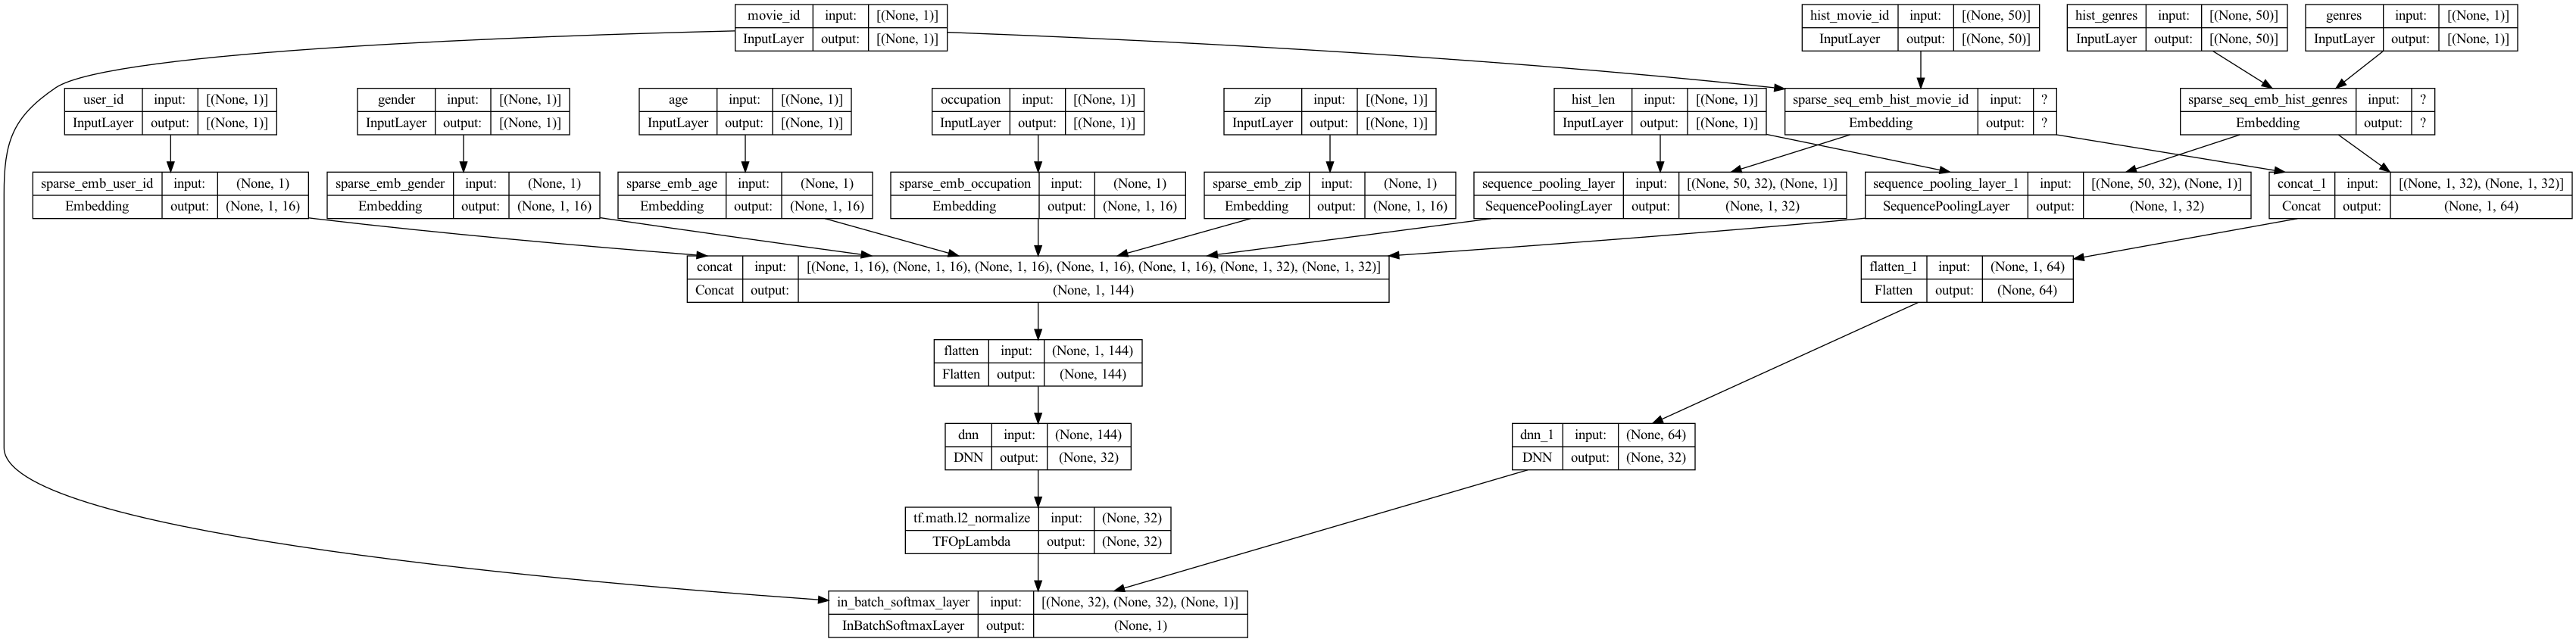

In [54]:
model.compile(loss=sampledsoftmaxloss, optimizer="adam")
history = model.fit(train_model_input, train_label,  # train_label,
                    batch_size=256, epochs=20, verbose=1, validation_split=0.0, )

tf.keras.utils.plot_model(model, to_file='DSSM_model.png', show_shapes=True)

# 6、Generate user features for testing and full item features for retrieval

In [55]:
test_user_model_input = test_model_input
len(test_user_model_input['user_id'])

6040

In [56]:
#前面生成的， item_profile  = data[['movie_id','genres']].drop_duplicates('movie_id')
all_item_model_input = {"movie_id": item_profile['movie_id'].values,"genres": item_profile['genres'].values}
user_embedding_modle = tf.keras.Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_modle = tf.keras.Model(inputs=model.item_input, outputs=model.item_embedding)

user_embs = user_embedding_modle.predict(test_user_model_input, batch_size=2 ** 12)
item_embs = item_embedding_modle.predict(all_item_model_input, batch_size=2 ** 12)
print(user_embs.shape)
print(item_embs.shape)

2/2 [==============================] - 0s 17ms/step


/Users/huanrongfu/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['movie_id', 'genres'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 64ms/step
(6040, 32)
(3706, 32)


# 7、使用faiss进行ANN查找并评估结果

In [57]:
#test_set, 是没有调用gen_model_Input前的数据，所以不包含user_frofile，也没有padding
#只取了userid和movie id{5791: [1444],1047: [2749],....}
test_true_label = {line[0]:[line[1]] for line in test_set}

In [ ]:
import numpy as np
import faiss

#faiss使用简介
#https://zhuanlan.zhihu.com/p/530958094
#三种索引方式：
#1. faiss.IndexFlatL2、indexFlatIP: L2欧氏距离以及点积的精确索引，也是说的暴力方式。
#2. faiss.IndexIVFFlat: 先进行聚类的倒排索引，支持欧式距离和向量内积两种距离算法
#3. IndexIVFPQ: 加聚类、加量化的倒排索引
#faiss.normalize_L2(item_embs)因为模型训练时已经L2了，这里不再需要了
embedding_dim = 32
index = faiss.IndexFlatIP(embedding_dim)
index.add(item_embs)
#search第一个参数是query, 第二是topk

Dis,Ind = index.search(np.ascontiguousarray(user_embs),50)
Dis


In [ ]:
item_profile['movie_id'].valuses

In [ ]:
def recall_N(y_true, y_pred, N=50):
    return len(set(y_pred[:N]) & set(y_true)) * 1.0 / len(y_true)

In [ ]:
#enumerate() 函数属于非常有用的高级用法，而对于这一点，
#很多初学者甚至中级学者都没有意识到。这个函数的基本应用就是用来遍历一个集合对象，
#它在遍历的同时还可以得到当前元素的索引位置。
s=[]
#前面test_user_model_input = test_model_input
for i, uid in enumerate(test_user_model_input['user_id']):
    try:
        #得到预测的那些movie_ids,为什么不直接用I[i]
        pred = [item_profile['movie_id'].values[x] for x in I[i]]
        filter_item = None
        recall_score = recall_N(test_true_lable[uid],pred,N=50)
        s.append(recall_score)
        if test_true_label[uid] in pred:
            hit +=1
    except:
        print(i)
print("")
print("recall", np.mean(s))
print("hit rate", hit /len(test_user_model_input['user_id']))